# Setting up Colab env
Google Drive, fast.ai, torch and torchvision. **Skip if running in Jupyter.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
!pip install 'torch==1.4' 'torchvision==0.5.0'

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 37.2MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


# Resnet34 transfer learning

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *
from fastai.metrics import error_rate

In [6]:
DATA_PATH = 'drive/My Drive/data/train'
MODEL_OUTPATH = 'drive/My Drive/'

train_dir = Path(DATA_PATH)

### Using default augmentation transforms

In [7]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

## Constructing ImageDataBunch object

In [13]:
data = ImageDataBunch.from_folder(
    train_dir, 
    valid_pct = .15, # % of data for validation
    seed = 420,
    ds_tfms = get_transforms(), # transforms for data augmentation
    size = 224, # image resizing
    bs = 64, # setting batch size
    ).normalize(imagenet_stats) # input data normalization according to imagnet dataset metrics

## Dataset details
Training and validation sets sizes, class balance.

In [14]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['cat', 'dog', 'human'], 29954, 5286)

In [15]:
total_size = 0
train_ds_summary = data.train_ds.to_df().groupby('y').count().to_dict()['x']
for c, size in train_ds_summary.items():
  total_size += size

for c, size in train_ds_summary.items():
  print(c, size/total_size * 100)

cat 34.092274821392806
dog 31.000867997596316
human 34.90685718101088


In [16]:
total_size = 0
valid_ds_summary = data.valid_ds.to_df().groupby('y').count().to_dict()['x']
for c, size in train_ds_summary.items():
  total_size += size

for c, size in train_ds_summary.items():
  print(c, size/total_size * 100)

cat 34.092274821392806
dog 31.000867997596316
human 34.90685718101088


## Model transfer learning with [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html#Training-with-the-1cycle-policy)

In [35]:
learn_resn34 = cnn_learner(data, models.resnet34, metrics=error_rate)

In [28]:
learn_resn34.summary()

### Search for optimal learning rate

In [19]:
learn_resn34.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


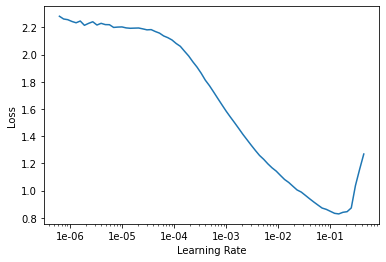

In [20]:
learn_resn34.recorder.plot()

In [36]:
learn_resn34.fit_one_cycle(8, max_lr=slice(.0003, .05))

epoch,train_loss,valid_loss,error_rate,time
0,0.097809,0.048099,0.012486,06:58
1,0.132068,0.152747,0.022701,06:59
2,0.080857,0.050427,0.010405,07:01
3,0.101324,0.027721,0.006621,07:03
4,0.062682,0.162269,0.008702,07:05
5,0.035160,0.019407,0.004729,07:07
6,0.025526,0.013216,0.003784,07:07
7,0.020811,0.015220,0.004540,07:09


Saving training stage

In [37]:
learn_resn34.save('stage-1-34')

## Model export

In [38]:
learn_resn34.path = Path(MODEL_OUTPATH)

In [39]:
learn_resn34.export()

## Inference

In [40]:
interp = ClassificationInterpretation.from_learner(learn_resn34)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In total 24 pictures from validation dataset were misclassified. Two pictures have wrong labels (humans labelled as dogs). Other two pictures have both cat and dog, where one of them is labelled wrong (dog occupies more pixels in the photo).

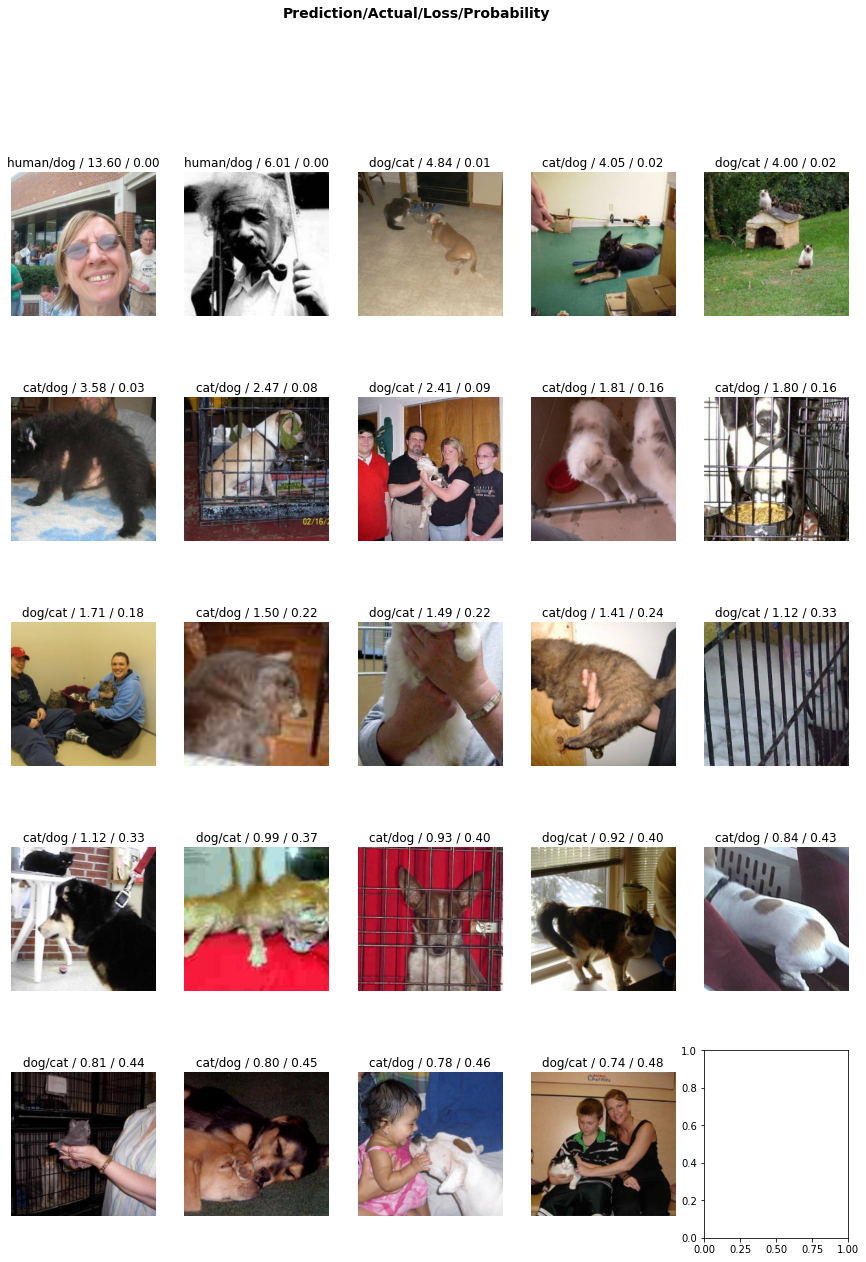

In [50]:
interp.plot_top_losses(24, figsize=(15,20))

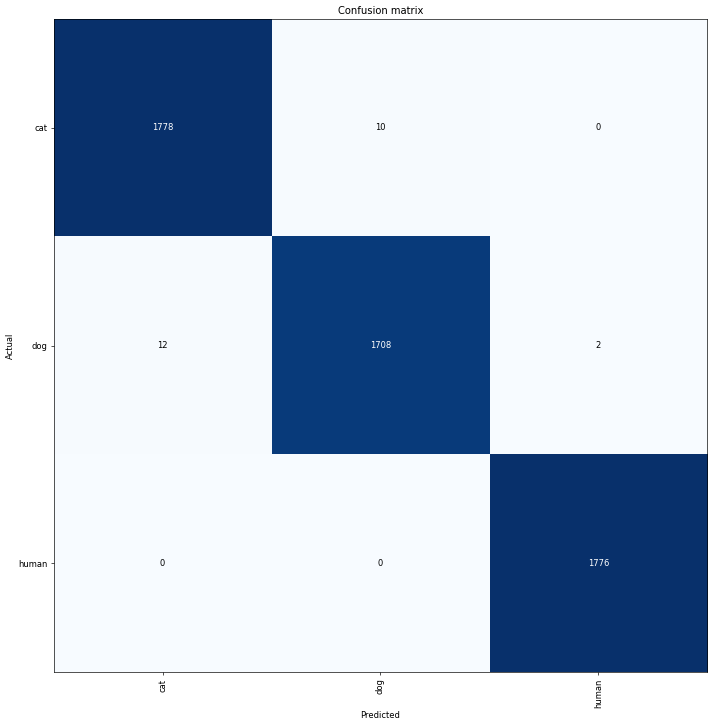

In [42]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)